##### Installing required libararies

In [41]:
!pip install transformers numpy pandas matplotlib nltk wordcloud


Importing here all necessary librarie

In [42]:
pip install torch

In [43]:
import pandas as pd
import re
import numpy as np
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

through pandas accessing database

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import tarfile

# Extract the tar file
tar_file_path = '/content/drive/MyDrive/ml_project/advices_assignments.tar (5)'
with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall(path='/content/drive/MyDrive/ml_project/extracted')

In [46]:
df = pd.read_csv("/content/drive/MyDrive/ml_project/extracted/advices_assignment.csv")

In [47]:
df

,advice
0,"['Drink plenty of water', 'eat hot food']"
1,"['avoid oily and spicy foods', 'take steam thr..."
2,"['avoid oily and spicy foods', 'take steam thr..."
3,['ors ']
4,"['avoid oily and spicy foods', 'take steam thr..."
...,...
9980,"['Eat khicdi', 'Drink coconut water', 'Avoid t..."
9981,"['Warm saline gargle ', 'Avoid cold beverages ..."
9982,"['Avoid Cold water,Curd&Fruits', 'Gargle with ..."
9983,"['Avoid Spicy Food', 'Drink plenty of water', ..."


Removing duplicates from the advice column

In [48]:
df = df.drop_duplicates(subset=['advice'])

Dropping null values

In [49]:
df = df.dropna(subset=['advice'])

First 10 rows of advice column

In [50]:
df.head(10)


,advice
0,"['Drink plenty of water', 'eat hot food']"
1,"['avoid oily and spicy foods', 'take steam thr..."
3,['ors ']
5,"['eat hot food', 'normal regular diet ', 'all ..."
6,"['Take Rest', 'Drink plenty of water', 'monito..."
7,"['Steam inhalation 4x a day', 'Monitor BP, SPO..."
8,"['avoid oily and spicy foods', 'salt water gar..."
9,"['Eat khicdi', 'Drink coconut water', 'Avoid t..."
10,"['Take Rest', 'Drink plenty of water', 'take s..."
11,"['avoid oily and spicy foods', 'take steam thr..."


In [51]:
df.columns

Index(['advice'], dtype='object')

In [52]:
df.nunique()

,0
advice,5000


In [53]:
df.isnull().sum()

,0
advice,0


In [54]:
df.describe()

,advice
count,5000
unique,5000
top,"['Drink plenty of water', 'eat hot food']"
freq,1


cleaning the data: removing punctuations

In [55]:
def clean_text(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


df['cleaned_advice'] = df['advice'].apply(clean_text)
advice_corpus = df['cleaned_advice'].tolist()


In [56]:
advice_corpus

['Drink plenty of water eat hot food',
 'avoid oily and spicy foods take steam thrice a day for seven days check SpO2 levels every 4 hrs Drink plenty of water',
 'ors',
 'eat hot food normal regular diet all foods can be given use mask social distancing isolation for 14 days warm water sips monitor spo2 regularly every 4th hourly do breathing exercises Take Rest Drink plenty of water',
 'Take Rest Drink plenty of water monitor spo2 steam inhalation',
 'Steam inhalation 4x a day Monitor BP SPO2 and Temperature every 6 hours Consult a physician if fever persists BP goes below 10050 or SPO2 drops below 95 Consult if you develop any other symptoms To contact physican if you develop fever or cough Lie in Prone Position 24 hours 48 times a day Continue Routine medication for Comorbidities if any Drink warm fluids like soup ginger teakhada etc Take Rest Avoid physical exertion Strenuous Exercise',
 'avoid oily and spicy foods salt water gargles',
 'Eat khicdi Drink coconut water Avoid travell

Here, I'm using tokenizer from BERT model

In [58]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Here, I'm performing basic statistics on advice_corpus data

In [59]:
num_documents = len(advice_corpus)
document_lengths = [len(tokenizer.tokenize(text)) for text in advice_corpus]

print(f"Number of documents: {num_documents}")
print(f"Average document length: {np.mean(document_lengths):.2f}")
print(f"Minimum document length: {np.min(document_lengths)}")
print(f"Maximum document length: {np.max(document_lengths)}")

Number of documents: 5000
Average document length: 20.78
Minimum document length: 0
Maximum document length: 419


In [61]:
all_tokens = [token for text in advice_corpus for token in tokenizer.tokenize(text.lower())]

Counting most frequent words in advice_corpus data

In [62]:
word_freq = Counter(all_tokens)
print("Most frequent words:", word_freq.most_common(10))

Most frequent words: [('water', 3064), ('of', 2277), ('avoid', 2065), ('and', 1886), ('drink', 1791), ('plenty', 1729), ('take', 1689), ('##s', 1591), ('for', 1544), ('in', 1526)]


making word cloud based on word frequency

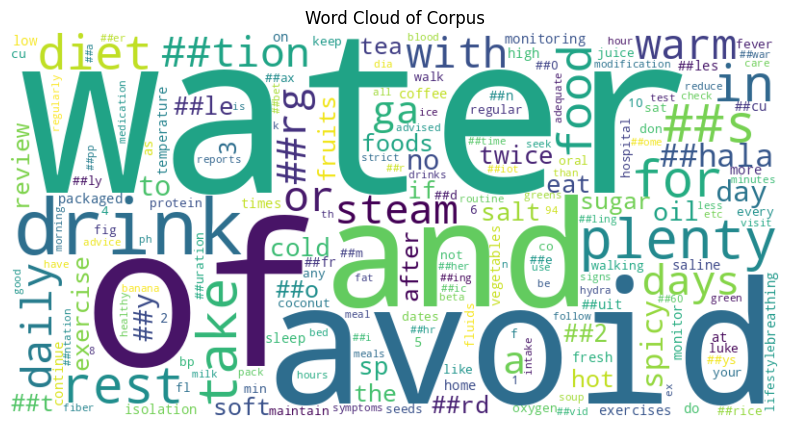

In [63]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Corpus')
plt.show()

Here, I'm creating functions for easy to create embeddings for both query and advice_corpus



In [64]:
def create_embedding(text):
    tokenized_text = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        output = model(**tokenized_text)
    return output.last_hidden_state.mean(dim=1).squeeze().numpy()

In [65]:
def create_corpus_embeddings(corpus):
    embeddings = []
    for text in corpus:
        embeddings.append(create_embedding(text))
    return np.array(embeddings)

Here, I have created this function to retrieve top 10 matches using cosine similarity property¶

In [66]:
def retrieve_top_matches(query_embedding, corpus_embeddings, top_k=10):
    similarities = cosine_similarity([query_embedding], corpus_embeddings).flatten()
    top_indices = similarities.argsort()[-top_k:][::-1]
    return top_indices, similarities[top_indices]

Here, I'm visualizing embeddings in 2 dimensional space

In [67]:
def visualize_embeddings_tsne(embeddings):
    embedding_array = np.array(embeddings)
    reduced_embeddings_tsne = TSNE(n_components=2).fit_transform(embedding_array)
    plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c='blue')
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

In [68]:
corpus = advice_corpus

Here, I'm generating embeddings for advice corpus data

In [ ]:
corpus_embeddings = create_corpus_embeddings(corpus)

Here, I'm visualizing the embeddings in 2-D space

In [ ]:
corpus_embeddings

array([[ 0.22013791,  0.15717791, -0.06750568, ..., -0.1317475 ,
        -0.3279193 , -0.20852597],
       [ 0.10668631,  0.1298338 ,  0.19894452, ..., -0.2541282 ,
        -0.04674335, -0.22303982],
       [ 0.06687501, -0.2143841 , -0.15521845, ..., -0.05597276,
         0.07049456,  0.20963296],
       ...,
       [-0.1080645 ,  0.21559969,  0.1963539 , ..., -0.52621174,
        -0.22711791, -0.41755173],
       [-0.25915805,  0.26590702,  0.076837  , ..., -0.20030935,
        -0.29797617,  0.01672294],
       [ 0.01391376,  0.19345665,  0.47045967, ..., -0.4744391 ,
        -0.02229331, -0.09238154]], dtype=float32)

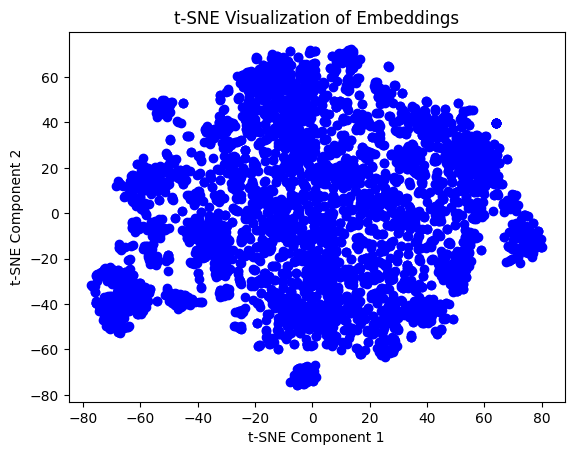

In [ ]:
visualize_embeddings_tsne(corpus_embeddings)

Here, I'm asking query

In [ ]:
query = "I pain in legs"

creating embeddings for query text

In [ ]:
query_embedding = create_embedding(query)

Here, I'm retrieving top 10 matches related to query in advice_copus

In [ ]:
top_indices, similarities = retrieve_top_matches(query_embedding, corpus_embeddings)

In [ ]:
for idx, sim in zip(top_indices, similarities):
    print(f"Similarity: {sim:.4f} - {corpus[idx]}")

Similarity: 0.7177 - No oil No water in ear
Similarity: 0.7059 - Try to put head without pillow
Similarity: 0.6960 - Hot fomantation Take rest for 2 weeks
Similarity: 0.6952 - Do exercise of grip Try to catch different shape things
Similarity: 0.6933 - Walking with support Hot pack 3 times a day Avoid long time sitting
Similarity: 0.6899 - Repeat TVS pelvis after next menses
Similarity: 0.6878 - Keep ear dry Opinion of Neurologist for Ataxia
Similarity: 0.6870 - Sleep on floor only Try to put head without pillow
Similarity: 0.6851 - If leg wound ozzing pn fever persist review in OPD
Similarity: 0.6849 - Lift legs while sleeping Use compression stockingscrepe bandage on lower part of legs Yoga


In [ ]:
from transformers import BertModel, BertTokenizer

# Load the pre-trained BERT model and tokenizer
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Save the model and tokenizer to the specified path
model.save_pretrained('/content/drive/MyDrive/Ai in Healthcare/bert_model')
tokenizer.save_pretrained('/content/drive/MyDrive/Ai in Healthcare/bert_tokenizer')




('/content/drive/MyDrive/Ai in Healthcare/bert_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Ai in Healthcare/bert_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Ai in Healthcare/bert_tokenizer/vocab.txt',
 '/content/drive/MyDrive/Ai in Healthcare/bert_tokenizer/added_tokens.json')

In [ ]:
from transformers import BertModel, BertTokenizer

# Load the model and tokenizer
model = BertModel.from_pretrained('/content/drive/MyDrive/Ai in Healthcare/bert_model')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/Ai in Healthcare/bert_tokenizer')

# Now you can use the loaded model and tokenizer
inputs = tokenizer("I have a headache", return_tensors="pt")
outputs = model(**inputs)

# Get the embeddings for the query
embedding = outputs.last_hidden_state


In [ ]:
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.1669,  0.3922, -0.0239,  ..., -0.0372,  0.1337,  0.0584],
         [ 0.1291,  0.3634, -0.4306,  ...,  0.0052,  0.4202,  0.1682],
         [ 0.1770,  0.8148,  0.2948,  ..., -0.0973, -0.0889,  0.1504],
         [-0.7068,  0.5529,  0.4128,  ..., -0.1781,  0.1646,  0.7780],
         [-0.3310,  0.4310, -0.0041,  ...,  0.2319,  0.1017, -0.2448],
         [ 0.8469,  0.1296, -0.0859,  ..., -0.0094, -0.6437, -0.2413]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-7.5167e-01, -1.4964e-01,  5.8744e-01,  4.3188e-01, -2.7459e-01,
         -9.2625e-02,  6.8022e-01,  1.6841e-01,  1.9041e-01, -9.9842e-01,
          2.2453e-01,  2.0660e-01,  9.6032e-01, -2.5456e-01,  8.5271e-01,
         -4.3349e-01, -6.1101e-02, -4.5202e-01,  2.0010e-01, -5.6908e-01,
          3.0893e-01,  5.7572e-01,  5.7423e-01,  1.8498e-01,  2.7352e-01,
          1.9383e-01, -3.7214e-01,  8.5166e-01,  9.0194e-01,  6.0332e-01,
       

In [ ]:
embedding

tensor([[[ 0.1669,  0.3922, -0.0239,  ..., -0.0372,  0.1337,  0.0584],
         [ 0.1291,  0.3634, -0.4306,  ...,  0.0052,  0.4202,  0.1682],
         [ 0.1770,  0.8148,  0.2948,  ..., -0.0973, -0.0889,  0.1504],
         [-0.7068,  0.5529,  0.4128,  ..., -0.1781,  0.1646,  0.7780],
         [-0.3310,  0.4310, -0.0041,  ...,  0.2319,  0.1017, -0.2448],
         [ 0.8469,  0.1296, -0.0859,  ..., -0.0094, -0.6437, -0.2413]]],
       grad_fn=<NativeLayerNormBackward0>)

In [ ]:
import torch
from transformers import BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the model and tokenizer
model = BertModel.from_pretrained('/content/drive/MyDrive/Ai in Healthcare/bert_model')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/Ai in Healthcare/bert_tokenizer')

# Function to create embeddings for a query
def create_embedding(query):
    inputs = tokenizer(query, return_tensors='pt')
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(**inputs)
    # Take the mean of the last hidden state for the embedding
    embedding = outputs.last_hidden_state.mean(dim=1)
    return embedding.numpy()  # Convert to NumPy array

# Function to retrieve top matches using existing corpus_embeddings
def retrieve_top_matches(query_embedding, corpus_embeddings, top_k=5):
    similarities = cosine_similarity(query_embedding, corpus_embeddings)  # No need for .numpy() on query_embedding
    top_indices = similarities[0].argsort()[-top_k:][::-1]  # Get indices of top_k similarities
    return top_indices, similarities[0][top_indices]

# Example query
query = "I have asthma"
query_embedding = create_embedding(query)

# Assuming corpus_embeddings is already created and is a NumPy array
# Retrieve top matches
top_indices, similarities = retrieve_top_matches(query_embedding, corpus_embeddings)

# Display results
for idx, sim in zip(top_indices, similarities):
    print(f"Similarity: {sim:.4f} - {corpus[idx]}")


Similarity: 0.6715 - quit smoking
Similarity: 0.6623 - Start dating
Similarity: 0.6602 - Avoid alcohol
Similarity: 0.6582 - stop drinking
Similarity: 0.6564 - Diet


In [ ]:
from transformers import BertModel, BertTokenizer

# Load the model and tokenizer
model = BertModel.from_pretrained('/content/drive/MyDrive/Ai in Healthcare/bert_model')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/Ai in Healthcare/bert_tokenizer')

# Tokenize the input
inputs = tokenizer("I have a headache", return_tensors="pt")

# Get the outputs from the model
outputs = model(**inputs)

# Get the embeddings for the query
embedding = outputs.last_hidden_state

# Decode the input tokens back to words
decoded_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Convert tokens to a string, skipping special tokens
decoded_text = tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)

print("Decoded Tokens:", decoded_tokens)
print("Decoded Text:", decoded_text)


Decoded Tokens: ['[CLS]', 'i', 'have', 'a', 'headache', '[SEP]']
Decoded Text: i have a headache


In [ ]:
from transformers import AutoTokenizer, AutoModel

# Specify the same directory where the model and tokenizer were saved
save_directory = "/content/drive/MyDrive/Ai in Healthcare/bert_model"

# Load the saved tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(save_directory)
model = AutoModel.from_pretrained(save_directory)

print("Model and tokenizer loaded successfully!")


Model and tokenizer loaded successfully!


In [ ]:
from transformers import AutoTokenizer, AutoModel

# Specify the same directory where the model and tokenizer were saved
save_directory = "/content/drive/MyDrive/Ai in Healthcare/bert_model"

# Load the saved tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(save_directory)
model = AutoModel.from_pretrained(save_directory)

print("Model and tokenizer loaded successfully!")


Model and tokenizer loaded successfully!


AttributeError: 'BertModel' object has no attribute 'corpus_embeddings'

In [ ]:
import torch

# Function to create embeddings using the loaded model
def create_embedding(text, tokenizer, model):
    tokenized_text = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        output = model(**tokenized_text)
    return output.last_hidden_state.mean(dim=1).squeeze().numpy()

# Example query
query = "I have a headache"

# Create the embedding for the query
query_embedding = create_embedding(query, tokenizer, model)

print(f"Embedding for query '{query}':\n", query_embedding)


Embedding for query 'I have a headache':
 [ 4.70290892e-02  4.47312593e-01  2.71760225e-02 -3.10031176e-01
 -2.43649676e-01 -3.13360959e-01 -8.74066725e-02  6.81476116e-01
 -3.93184692e-01 -2.42738649e-01 -5.68231978e-02 -4.18228000e-01
 -1.97356399e-02  3.79679441e-01  1.26329184e-01  5.10634184e-02
  5.12589037e-01 -1.28213003e-01 -4.28230852e-01  6.84649408e-01
  4.32852536e-01 -3.91835980e-02 -4.61273521e-01  7.49322712e-01
  1.16741993e-02 -3.80464554e-01 -1.67526051e-01  3.65413308e-01
 -9.93665829e-02 -6.09444380e-01  3.13449174e-01 -1.37585059e-01
 -2.68950939e-01  3.38768601e-01  2.88777441e-01  1.93987325e-01
  2.11339816e-01 -2.89564788e-01 -3.10636848e-01 -7.56931528e-02
 -2.70960182e-01 -2.91153163e-01 -1.08899809e-01 -9.61123481e-02
  2.08331108e-01 -2.60505646e-01  4.92140561e-01 -3.50320458e-01
  1.41556278e-01 -2.33027697e-01  2.11234078e-01 -5.40216752e-05
  2.20765755e-01  1.32357687e-01 -5.21420455e-03  7.78755665e-01
 -2.69876689e-01 -3.53424340e-01 -2.57961839e-01

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
import numpy as np

# Load the model and tokenizer from the saved path
model = BertModel.from_pretrained("/content/drive/MyDrive/ml_project/bert_model")
tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/ml_project/bert_model")

# Set the model to evaluation mode
model.eval()

def create_embedding(text):
    # Tokenize and get embeddings
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Return the embeddings of the [CLS] token
    return outputs.last_hidden_state[:, 0, :].numpy()

def retrieve_top_matches(query_embedding, corpus_embeddings, top_n=5):
    # Compute cosine similarities
    similarities = np.dot(corpus_embeddings, query_embedding.T).flatten()
    top_indices = np.argsort(similarities)[-top_n:][::-1]  # Get indices of top matches
    return top_indices, similarities[top_indices]

corpus_embeddings = np.array([create_embedding(text) for text in corpus])

# Query
query = "I pain in legs"
query_embedding = create_embedding(query)

# Retrieve top matches
top_indices, similarities = retrieve_top_matches(query_embedding, corpus_embeddings)

# Print results
for idx, sim in zip(top_indices, similarities):
    print(f"Similarity: {sim:.4f} - {corpus[idx]}")


Similarity: 184.8181 - Empty stomach 8 AM
Similarity: 183.7634 - juice Blood pressure
Similarity: 182.8329 - Good sleep
Similarity: 182.7681 - Gargles with Luke warm water 6 hourly Take Rest
Similarity: 182.7586 - Mouth gargle


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

# Load the model and tokenizer from the saved path
model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/ml_project/bert_model")
tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/ml_project/bert_model")

# Example input text
text = "I have fever."

# Tokenize the input text
inputs = tokenizer(text, return_tensors="pt")

# Set the model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Get the predicted logits
logits = outputs.logits

# Convert logits to probabilities (if needed)
probabilities = torch.nn.functional.softmax(logits, dim=-1)

# Get the predicted class
predicted_class = torch.argmax(probabilities, dim=-1).item()

print(f"Predicted class: {predicted_class}")



Predicted class: 0
